In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ml_intensive_yandex_academy_spring_2025_path = kagglehub.competition_download('ml-intensive-yandex-academy-spring-2025')
kirachistiakova_baseline_path = kagglehub.notebook_output_download('kirachistiakova/baseline')

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary

In [ ]:
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
train_df = pd.read_csv("/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/train_answers.csv")
train_df

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


In [ ]:
train_df["target_feature"].value_counts(normalize=True)
# Видим, что в исходных данных всего 16 типов данных, а не 20, как в справочнике - потом надо переделать модель на 16 классов
# Потом можно добавить график

target_feature
0     0.203121
3     0.135845
9     0.098892
5     0.079405
6     0.064688
16    0.060888
4     0.060807
8     0.043099
2     0.042856
11    0.042694
12    0.037924
13    0.035740
18    0.033153
10    0.031536
14    0.018436
1     0.010916
Name: proportion, dtype: float64

In [ ]:
# Если делать модель на 20 классах,
# то на одних и тех же данных то метрика на валидации будет отличаться от метрики на нашей валидации.
# Например у нас f1 0.39, а на лидерборде около 0.5. Если классов сделать 16 (как на самом деле есть),
# то на этих же предсказаниях метрика будет уже 0.49 (f1 чуствительна к количеству классов)
# Самое просто это перекодировать классы. Например (просто берем по уменьшении доли класс)

target_feature_to_class_id = {
    0:0,
    3:1,
    9:2,
    5:3,
    6:4,
    16:5,
    4:6,
    8:7,
    2:8,
    11:9,
    12:10,
    13:11,
    18:12,
    10:13,
    14:14,
    1:15,
}

class_id_to_target_feature = {v:k for k,v in target_feature_to_class_id.items()}

print(f'target_feature -> class_id', target_feature_to_class_id)
print(f'class_id -> target_feature', class_id_to_target_feature)

target_feature -> class_id {0: 0, 3: 1, 9: 2, 5: 3, 6: 4, 16: 5, 4: 6, 8: 7, 2: 8, 11: 9, 12: 10, 13: 11, 18: 12, 10: 13, 14: 14, 1: 15}
class_id -> target_feature {0: 0, 1: 3, 2: 9, 3: 5, 4: 6, 5: 16, 6: 4, 7: 8, 8: 2, 9: 11, 10: 12, 11: 13, 12: 18, 13: 10, 14: 14, 15: 1}


In [ ]:
# Заменим 20 классов на новые идентификатры 16 классов
train_df['target_feature'] = train_df['target_feature'].replace(target_feature_to_class_id)
train_df

,img_id,target_feature
0,17363,8
1,8612,3
2,8244,0
3,9264,0
4,5382,4
...,...,...
12362,11503,6
12363,12201,4
12364,5489,1
12365,883,3


In [ ]:
# Разделим данные на train и valid сохранением доли таргета
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=5, shuffle=True, stratify=train_df["target_feature"])

In [ ]:
# Проверим, что доли таргета не поменялись. Потом можно добавить график
print(train_df["target_feature"].value_counts(normalize=True))
print(valid_df["target_feature"].value_counts(normalize=True))

target_feature
0     0.203174
1     0.135854
2     0.098858
3     0.079450
4     0.064692
5     0.060851
6     0.060851
7     0.043061
8     0.042859
9     0.042656
10    0.037906
11    0.035783
12    0.033155
13    0.031537
14    0.018397
15    0.010917
Name: proportion, dtype: float64
target_feature
0     0.202910
1     0.135812
2     0.099030
3     0.079224
4     0.064673
5     0.061035
6     0.060631
7     0.043250
8     0.042846
9     0.042846
10    0.037995
11    0.035570
12    0.033145
13    0.031528
14    0.018593
15    0.010914
Name: proportion, dtype: float64


In [ ]:
# Класс для загрузки картинок и информации о них
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg"
        img_path = os.path.join(self.img_dir, img_name)

        # Читаем изображение
        image = read_image(img_path)

        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']

        # Применяем трансформации, если они заданы
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torchvision.transforms import v2

transform_train = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomApply([v2.ColorJitter(0.1, 0.1, 0.1, 0.02)], p=0.8),
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid = v2.Compose([
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(
    df=train_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_train
)

valid_dataset = ImageDataset(
    df=valid_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_valid
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch.nn.functional as F

# Inception блок
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_before, ch3x3, ch5x5_before, ch5x5, after_pool):
        super(InceptionBlock, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_before, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_before, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_before, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_before, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, after_pool, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], dim=1)

# Основная модель
class CustomInception(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomInception, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


model = CustomInception(num_classes=16)
model=model.to(device)

In [ ]:
from torch.utils.data import WeightedRandomSampler, DataLoader

# # 1. Считаем количество классов и создаем веса
# class_counts = train_df['target_feature'].value_counts().sort_index().values
# class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
# class_weights = class_weights / class_weights.sum()  # нормализация
# class_weights = class_weights.to(device)

# # 2. Вычисляем веса для каждого примера в train_df
# sample_weights = np.array(
#     [class_weights[x].item() for x in train_df['target_feature']],
#     dtype=np.float32
# )

# # 3. Создаем WeightedRandomSampler
# sampler = WeightedRandomSampler(
#     weights=sample_weights,
#     num_samples=len(sample_weights),
#     replacement=True
# )
batch_size = 256

# У нас не очень много данных, но мы хотим батс 256 так что увеличим датасет в 3 раза
from torch.utils.data import ConcatDataset
train_dataloader = DataLoader(ConcatDataset([train_dataset, train_dataset, train_dataset]), batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['target_feature'].values),
    y=train_df['target_feature'].values
)
print(class_weights)

[0.30761816 0.46005394 0.63222137 0.78665712 0.96611328 1.02709718
 1.02709718 1.45143779 1.4582842  1.4651955  1.64883333 1.74664548
 1.88509909 1.98177083 3.39732143 5.72511574]


In [ ]:
# === Функция потерь ===
loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device),  # class_weights - усилим вес редких классов
    label_smoothing = 0.1,  # Сглаживание целевых классов
    )

# === Оптимизатор ===
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

In [ ]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Average, RunningAverage, Precision, Recall, Fbeta
from ignite.utils import convert_tensor

max_epoch = 100
validation_patience = 20

# Создание trainer
train_engine = create_supervised_trainer(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    output_transform=lambda x, y, y_pred, loss: (loss.item(), y_pred, y)
)

# Добавляем метрики для подсчета train_loss
train_loss = Average(output_transform=lambda x: x[0])
train_loss.attach(train_engine, 'train_loss')

# Создаем метрики Precision и Recall
P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))

# Создаем F1-метрику (Fbeta с beta=1)
# https://pytorch.org/ignite/generated/ignite.metrics.Fbeta.html#ignite.metrics.Fbeta
train_metric = Fbeta(beta=1.0, precision=P, recall=R)
train_metric.attach(train_engine, "train_f1")

# Создание Engine для валидации
valid_engine = create_supervised_evaluator(
    model=model,
    device=device,
    output_transform=lambda x, y, y_pred: (loss_fn(input=y_pred, target=y).item(), y_pred, y)
)

# Добавляем метрики для подсчета train_loss
valid_loss = Average(output_transform=lambda x: x[0])
valid_loss.attach(valid_engine, 'valid_loss')

# Создаем метрики Precision и Recall для валидации
P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))

# Создаем F1-метрику (Fbeta с beta=1)
# https://pytorch.org/ignite/generated/ignite.metrics.Fbeta.html#ignite.metrics.Fbeta
valid_metric = Fbeta(beta=1.0, precision=P, recall=R)
valid_metric.attach(valid_engine, "valid_f1")

train_loss_history = []
train_f1_history = []
valid_loss_history = []
valid_f1_history = []

# После каждой эпохи train_engine должен запускать valid_engine
# Создадим обработчик события - конец эпохи у train_engine
def compute_epoch_results(engine):
    valid_engine.run(valid_dataloader)
    train_loss = engine.state.metrics['train_loss']
    train_f1 = engine.state.metrics['train_f1']
    valid_loss = valid_engine.state.metrics['valid_loss']
    valid_f1 = valid_engine.state.metrics['valid_f1']

    train_loss_history.append(train_loss)
    train_f1_history.append(train_f1)
    valid_loss_history.append(valid_loss)
    valid_f1_history.append(valid_f1)

    print(f"Эпоха: {engine.state.epoch} train_loss: {train_loss:.4f} valid_loss: {valid_loss:.4f} train_f1: {train_f1:.4f} valid_f1: {valid_f1:.4f}")

train_engine.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

# Добавляем EarlyStopping
early_stop_handler = EarlyStopping(
    patience=validation_patience,  # количество эпох без улучшения
    score_function=lambda engine: -valid_engine.state.metrics['valid_loss'],
    trainer=train_engine
)

# Прикрепляем обработчик к train_engine
train_engine.add_event_handler(Events.EPOCH_COMPLETED, early_stop_handler)

# Добавляем сохранение лучших моделей
checkpointer = ModelCheckpoint(
    score_function=lambda engine: -valid_engine.state.metrics['valid_loss'],
    dirname="models",
    filename_prefix="baseline",
    n_saved=3,
    create_dir=True,
    require_empty=False,
)
# Прикрепляем обработчик к train_engine
train_engine.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})

# Создаем прогресс-бар
progress_bar = ProgressBar()

# Привязываем к trainer
progress_bar.attach(train_engine)

# Запускаем обучение
engine_output = train_engine.run(train_dataloader, max_epochs=max_epoch)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

ValueError: attempt to get argmin of an empty sequence

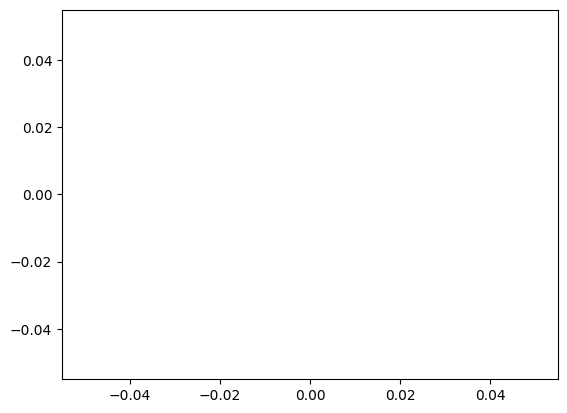

In [ ]:
plt.plot(range(len(train_loss_history)), train_loss_history, label="train_loss")
plt.plot(range(len(valid_loss_history)), valid_loss_history, label="valid_loss")

best_epoch = np.argmin(np.array(valid_loss_history))
plt.axvline(x=best_epoch, color='red', label="best valid_loss epoch")

plt.legend()
plt.show()

plt.plot(range(len(train_f1_history)), train_f1_history, label="train_f1")
plt.plot(range(len(valid_f1_history)), valid_f1_history, label="valid_f1")

plt.axvline(x=best_epoch, color='red', label="best valid_loss epoch")

plt.legend()
plt.show()

In [ ]:
# Соберем pandas DataFrame для тестовых данных и из него сделаем тестовый датасет
file_list = os.listdir('/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test')
img_id_list = [int(file_name.split(".")[0]) for file_name in file_list]

In [ ]:
test_df = pd.DataFrame({
    "img_id": img_id_list,
    "target_feature": -1
})
test_df

,img_id,target_feature
0,16916,-1
1,12666,-1
2,623,-1
3,11925,-1
4,2008,-1
...,...,...
5296,728,-1
5297,1656,-1
5298,3361,-1
5299,2599,-1


In [ ]:
test_dataset = ImageDataset(
    df=test_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test",
    transform=transform_valid
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_engine = create_supervised_evaluator(
    model=model,
    device=device,
    output_transform=lambda x, y, y_pred: y_pred
)

test_pred_list = []

def compute_epoch_results(engine):
    test_pred_list.append(engine.state.output.cpu().numpy())

test_engine.add_event_handler(Events.ITERATION_COMPLETED, compute_epoch_results)

# Создаем прогресс-бар
progress_bar = ProgressBar()

# Привязываем к trainer
progress_bar.attach(test_engine)

# Запускаем предсказание
test_engine_output = test_engine.run(test_dataloader)

[1/42]   2%|2          [00:00<?]

In [ ]:
# Объединяем предсказания в разных batch
test_pred = np.concatenate(test_pred_list)
test_pred.shape

In [ ]:
# Максимум это предсказанный класс
test_pred = test_pred.argmax(1)
test_pred.shape

In [ ]:
# Мы заменяли 20 классов на наши 16 - теперь надо вернуть нормально
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)

In [ ]:
# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred

In [ ]:
# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

In [ ]:
# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result.csv', index=False)